In [41]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

In [42]:
# ---------- CONFIG ----------
DATA_PATH = "datasets/cleaned/merged_fx_dataset.csv"   # change if needed
OUT_DIR = "./"
TEST_FRACTION = 0.2
MIN_TEST_WEEKS = 24
Y_COL = "Buying"

In [43]:
# ---------- HELPERS ----------
def evaluate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = float(np.mean(np.abs((np.asarray(y_true) - np.asarray(y_pred)) /
                                np.maximum(np.abs(y_true), 1e-6))) * 100.0)
    return {"MAE": mae, "RMSE": rmse, "R2": r2, "MAPE_%": mape}


def is_strictly_positive(s: pd.Series) -> bool:
    x = s.dropna()
    return (len(x) > 0) and (x.min() > 0)


def make_ml_features(frame: pd.DataFrame, y_col="y", max_lag=4, roll_windows=(4, 8)):
    out = frame.copy()
    # y lags
    for L in range(1, max_lag + 1):
        out[f"{y_col}_lag{L}"] = out[y_col].shift(L)
    # exog lags
    ex_cols = [c for c in frame.columns if c != y_col]
    for L in range(1, max_lag + 1):
        for c in ex_cols:
            out[f"{c}_lag{L}"] = out[c].shift(L)
    # rolling stats on y
    for w in roll_windows:
        out[f"{y_col}_rollmean_{w}"] = out[y_col].rolling(w).mean()
        out[f"{y_col}_rollstd_{w}"] = out[y_col].rolling(w).std()
    return out


def invert_dlog_to_level(dlog_series: pd.Series, start_log_value: float) -> pd.Series:
    """Reconstruct levels from Δlog series given the last pre-period log level."""
    cumlog = np.cumsum(dlog_series.values) + start_log_value
    return pd.Series(np.exp(cumlog), index=dlog_series.index, name="Level")

In [44]:
# ---------- 1) LOAD & CLEAN ----------
df = pd.read_csv(DATA_PATH)
assert "Date" in df.columns and Y_COL in df.columns, "Dataset must have 'Date' and 'Buying' columns."
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").drop_duplicates("Date").set_index("Date")

In [73]:
df.head()

,Buying,Selling,MidRate,MPR,GhInflationRate,BrentOil,Cocoa,Gold,GhInterestRate,NetForeignAssets,NIR,Imports,Exports,GhGDP,USGDP,USInflationRate,USInterestRate
Date,,,,,,,,,,,,,,,,,
2008-01-02,0.9545,0.9799,0.9672,13.5,12.81,91.9,2174.5,891.0,12.175,1979.35,1674.3,781.9,406.1,18863.43405,16843.003,87.093,4.11
2008-01-03,0.9545,0.9799,0.9672,13.5,12.81,91.9,2174.5,891.0,12.175,1979.35,1674.3,781.9,406.1,18863.43405,16843.003,87.093,4.25
2008-01-04,0.9543,0.9798,0.9671,13.5,12.81,91.9,2174.5,891.0,12.175,1979.35,1674.3,781.9,406.1,18863.43405,16843.003,87.093,4.18
2008-01-07,0.9551,0.9809,0.9680,13.5,12.81,91.9,2174.5,891.0,12.175,1979.35,1674.3,781.9,406.1,18863.43405,16843.003,87.093,4.27
2008-01-08,0.9576,0.9800,0.9688,13.5,12.81,91.9,2174.5,891.0,12.175,1979.35,1674.3,781.9,406.1,18863.43405,16843.003,87.093,4.27


In [74]:
df.tail()

,Buying,Selling,MidRate,MPR,GhInflationRate,BrentOil,Cocoa,Gold,GhInterestRate,NetForeignAssets,NIR,Imports,Exports,GhGDP,USGDP,USInflationRate,USInterestRate
Date,,,,,,,,,,,,,,,,,
2024-12-23,14.6427,14.6573,14.65,27.0,23.82,73.18,10869.14,2641.45,27.03,3815.3387,6376.097,1266.31,1581.28,53957.1,23542.349,123.98,4.33
2024-12-24,14.6427,14.6573,14.65,27.0,23.82,73.18,10869.14,2641.45,27.03,3815.3387,6376.097,1266.31,1581.28,53957.1,23542.349,123.98,4.33
2024-12-27,14.6927,14.7074,14.70,27.0,23.82,73.18,10869.14,2641.45,27.03,3815.3387,6376.097,1266.31,1581.28,53957.1,23542.349,123.98,4.33
2024-12-30,14.7026,14.7174,14.71,27.0,23.82,73.18,10869.14,2641.45,27.03,3815.3387,6376.097,1266.31,1581.28,53957.1,23542.349,123.98,4.33
2024-12-31,14.6927,14.7074,14.70,27.0,23.82,73.18,10869.14,2641.45,27.03,3815.3387,6376.097,1266.31,1581.28,53957.1,23542.349,123.98,4.33


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4217 entries, 2008-01-02 to 2024-12-31
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Buying            4217 non-null   float64
 1   Selling           4217 non-null   float64
 2   MidRate           4217 non-null   float64
 3   MPR               4217 non-null   float64
 4   GhInflationRate   4217 non-null   float64
 5   BrentOil          4217 non-null   float64
 6   Cocoa             4217 non-null   float64
 7   Gold              4217 non-null   float64
 8   GhInterestRate    4217 non-null   float64
 9   NetForeignAssets  4217 non-null   float64
 10  NIR               4217 non-null   float64
 11  Imports           4217 non-null   float64
 12  Exports           4217 non-null   float64
 13  GhGDP             4217 non-null   float64
 14  USGDP             4217 non-null   float64
 15  USInflationRate   4217 non-null   float64
 16  USInterestRate    4217 n

<Axes: xlabel='Date'>

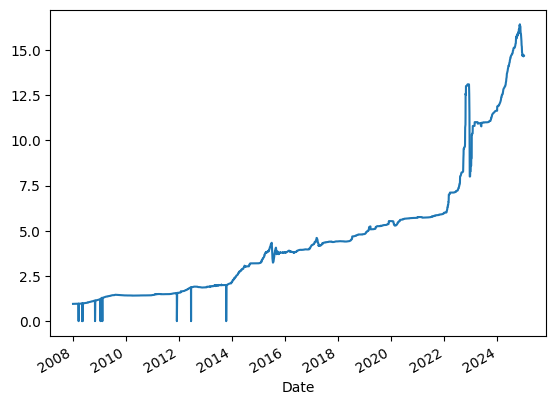

In [46]:
df['Buying'].plot()

In [47]:
# Fix exact-zero targets → NaN → interpolate (common data issue)
if (df[Y_COL] == 0).any():
    df.loc[df[Y_COL] == 0, Y_COL] = np.nan
    df[Y_COL] = df[Y_COL].interpolate(method="time").ffill().bfill()

# Choose predictors: macro + commodities; drop near-duplicates of target
drop_cols = {"Buying", "MidRate", "Selling"}
exog_cols = [c for c in df.columns if c not in drop_cols]
num_cols = [c for c in exog_cols if np.issubdtype(
    df[c].dropna().dtype, np.number)]

work = df[[Y_COL] + num_cols].copy()

In [48]:
# ---------- 2) RESAMPLE TO WEEKLY & BUILD Δ FEATURES ----------
wk = work.resample("W-FRI").last().dropna(how="all")
wk["log_Buying"] = np.log(wk[Y_COL])
wk["y"] = wk["log_Buying"].diff()  # target: Δlog(Buying)

# Exogenous deltas (Δlog if strictly positive; else simple diff)
X_delta = pd.DataFrame(index=wk.index)
for c in num_cols:
    s = wk[c]
    if is_strictly_positive(s):
        X_delta[c + "_dlog"] = np.log(s).diff()
    else:
        X_delta[c + "_diff"] = s.diff()

data = pd.concat([wk[["y"]], X_delta], axis=1).dropna()

In [49]:
# ---------- 3) FEATURE ENGINEERING FOR XGB ----------
ml_df = make_ml_features(data, y_col="y", max_lag=4,
                         roll_windows=(4, 8)).dropna()

In [50]:
# Time split
n = len(ml_df)
test_size = max(int(TEST_FRACTION * n), MIN_TEST_WEEKS)
train_df = ml_df.iloc[:-test_size].copy()
test_df = ml_df.iloc[-test_size:].copy()
y_train, X_train = train_df["y"], train_df.drop(columns=["y"])
y_test,  X_test = test_df["y"],  test_df.drop(columns=["y"])

In [51]:
xgb_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("xgb", XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=4
    ))
])

In [52]:
# Rolling-origin CV on train
tscv = TimeSeriesSplit(n_splits=5)
cv_preds = np.empty_like(y_train.values)
cv_preds[:] = np.nan
for tr_idx, val_idx in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    xgb_pipe.fit(X_tr, y_tr)
    cv_preds[val_idx] = xgb_pipe.predict(X_val)

In [53]:
mask = ~np.isnan(cv_preds)
cv_metrics = evaluate_metrics(y_train.values[mask], cv_preds[mask])

# Fit final on full train, eval on test
xgb_pipe.fit(X_train, y_train)
test_pred = xgb_pipe.predict(X_test)
test_metrics = evaluate_metrics(y_test.values, test_pred)

In [72]:
metrics_df = pd.DataFrame([
    {"Model": "XGBoost (lags+rolls)", "Split": "CV",   **
     {k: round(v, 6) for k, v in cv_metrics.items()}},
    {"Model": "XGBoost (lags+rolls)", "Split": "TEST", **
     {k: round(v, 6) for k, v in test_metrics.items()}},
])
metrics_df

,Model,Split,MAE,RMSE,R2,MAPE_%
0,XGBoost (lags+rolls),CV,0.003886,0.010647,0.198773,4154.981140
1,XGBoost (lags+rolls),TEST,0.010494,0.038565,0.126759,16684.419178


In [ ]:
# ---------- 5) SAVE METRICS, PREDS, FEATURE IMPORTANCES ----------


# metrics_path = os.path.join(OUT_DIR, "xgb_fx_metrics.csv")
# metrics_df.to_csv(metrics_path, index=False)

preds_df = pd.DataFrame({
    "Date": y_test.index,
    "y_true_dlog": y_test.values,
    "y_pred_dlog": test_pred
}).set_index("Date")

# preds_path = os.path.join(OUT_DIR, "xgb_fx_predictions.csv")
# preds_df.to_csv(preds_path)

xgb_model = xgb_pipe.named_steps["xgb"]
fi = pd.DataFrame({"Feature": X_train.columns, "Importance": xgb_model.feature_importances_}) \
       .sort_values("Importance", ascending=False).reset_index(drop=True)
fi_top = fi.head(min(30, len(fi)))
# fi_path = os.path.join(OUT_DIR, "xgb_feature_importances_top30.csv")
# fi_top.to_csv(fi_path, index=False)

In [58]:
fi_top

,Feature,Importance
0,y_rollmean_4,0.085863
1,y_rollstd_4,0.078813
2,y_lag4,0.068116
3,y_lag1,0.066223
4,y_rollstd_8,0.053427
5,y_rollmean_8,0.050453
6,y_lag2,0.047153
7,y_lag3,0.044701
8,Gold_dlog_lag1,0.039068
9,USInterestRate_dlog,0.034698


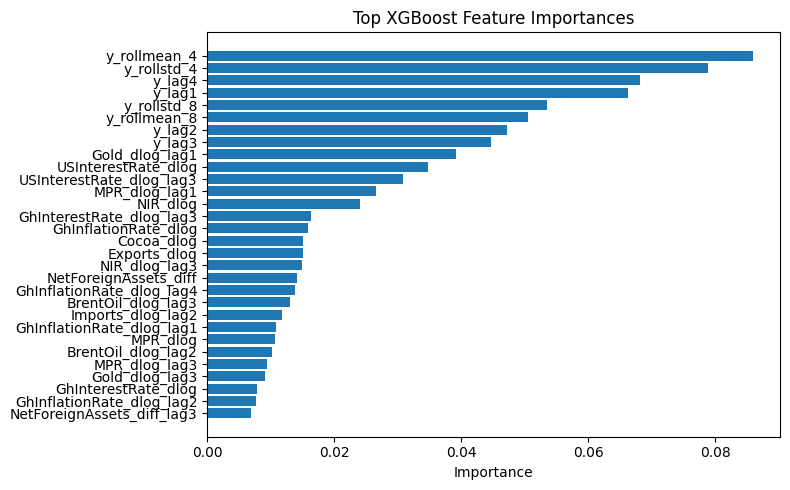

In [70]:
plt.figure(figsize=(8,5))
plt.barh(fi_top["Feature"], fi_top["Importance"])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Top XGBoost Feature Importances")
plt.tight_layout()
plt.savefig('plots/xgb/xgb_feature_importance.png')
plt.show()

In [60]:
# ---------- 6) PLOTS ----------
# Reconstruct levels for visualization (optional)
pre_test_idx = wk.index[wk.index < y_test.index[0]]
assert len(pre_test_idx) > 0, "Need at least 1 observation before test start."
anchor_log = wk.loc[pre_test_idx[-1], "log_Buying"]

true_level = invert_dlog_to_level(
    pd.Series(y_test.values, index=y_test.index), anchor_log)
xgb_level = invert_dlog_to_level(
    pd.Series(test_pred,  index=y_test.index), anchor_log)
rw_level = invert_dlog_to_level(
    pd.Series(np.zeros_like(y_test.values), index=y_test.index), anchor_log)

In [66]:
true_vs_pred_df = pd.DataFrame({
    "Date": y_test.index,
    "Actual_Buying_Level": true_level.values,
    "XGBoost_Predicted_Level": xgb_level.values,
    "Random_Walk_Level": rw_level.values
}).set_index("Date")

In [67]:
true_vs_pred_df.head()

,Actual_Buying_Level,XGBoost_Predicted_Level,Random_Walk_Level
Date,,,
2021-08-27,5.8473,5.843596,5.8307
2021-09-03,5.8535,5.860974,5.8307
2021-09-10,5.8532,5.869922,5.8307
2021-09-17,5.8601,5.874804,5.8307
2021-09-24,5.8614,5.877812,5.8307


In [68]:
true_vs_pred_df.tail()

,Actual_Buying_Level,XGBoost_Predicted_Level,Random_Walk_Level
Date,,,
2024-12-06,14.8626,13.421681,5.8307
2024-12-13,14.7326,13.276318,5.8307
2024-12-20,14.6927,13.234245,5.8307
2024-12-27,14.6927,13.323839,5.8307
2025-01-03,14.6927,13.395517,5.8307


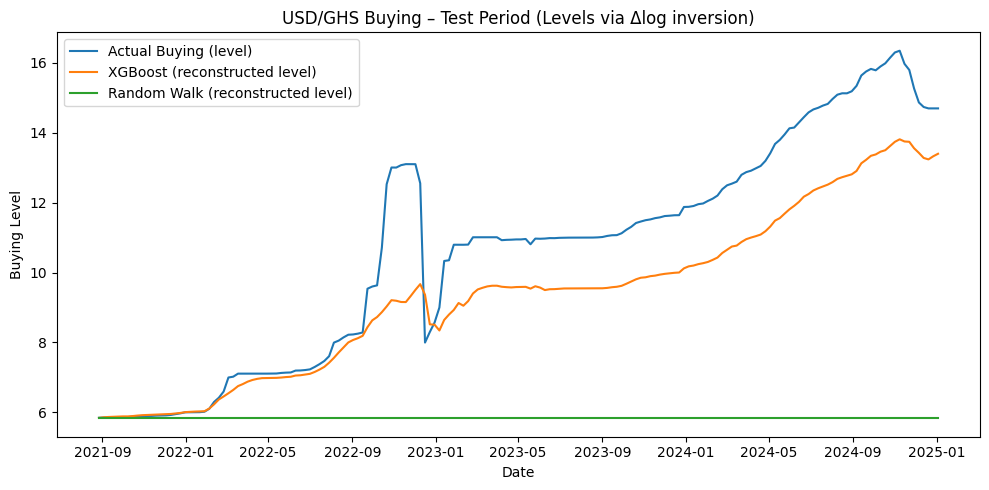

In [64]:
plt.figure(figsize=(10, 5))
plt.plot(true_level.index, true_level.values, label="Actual Buying (level)")
plt.plot(xgb_level.index, xgb_level.values,
         label="XGBoost (reconstructed level)")
plt.plot(rw_level.index,  rw_level.values,
         label="Random Walk (reconstructed level)")
plt.title("USD/GHS Buying – Test Period (Levels via Δlog inversion)")
plt.xlabel("Date")
plt.ylabel("Buying Level")
plt.legend()
plt.tight_layout()
plt.savefig('plots/xgb/xgb_vs_random_walk_actual_vs_predicted.png')
plt.show()

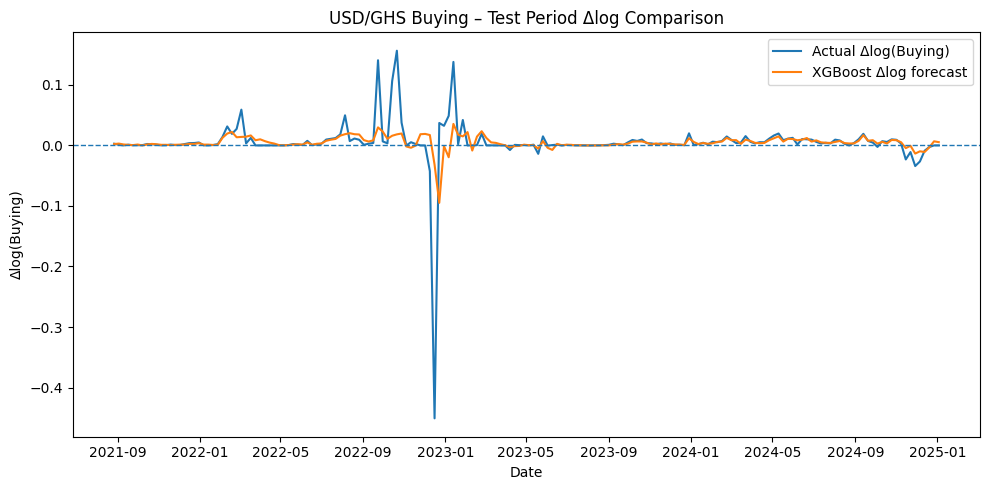

In [69]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test.values, label="Actual Δlog(Buying)")
plt.plot(y_test.index, test_pred,     label="XGBoost Δlog forecast")
plt.axhline(0.0, linestyle="--", linewidth=1)
plt.title("USD/GHS Buying – Test Period Δlog Comparison")
plt.xlabel("Date")
plt.ylabel("Δlog(Buying)")
plt.legend()
plt.tight_layout()
plt.show()